# Training

In [1]:
%pip install -r ../requirements.txt

You should consider upgrading via the '/home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Neural Network

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['ABSL_LOG_THRESHOLD'] = '0'

import time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from sklearn.utils.class_weight import compute_class_weight


print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("Is TensorFlow using GPU?", tf.test.is_gpu_available())
print("GPU disponível:", tf.config.list_physical_devices('GPU'))
print("XLA ativado:", tf.config.optimizer.get_jit())
# Mostra configuração geral
tf.config.experimental.list_physical_devices()

2025-04-23 18:09:54.226998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745442594.241389   48789 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745442594.245595   48789 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745442594.257616   48789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745442594.257642   48789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745442594.257643   48789 computation_placer.cc:177] computation placer alr

TensorFlow: 2.19.0
Keras: 3.9.2
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is TensorFlow using GPU? True
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
XLA ativado: 


I0000 00:00:1745442596.338591   48789 gpu_device.cc:2019] Created device /device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:0a:00.0, compute capability: 7.5


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
TRAINING_DATASET_PATH = '../datasets/training'
TRAINING_DATASET_VERSION = 'v2'

TRAINING_DATASET_VERSION_PATH = Path(os.path.join(TRAINING_DATASET_PATH, TRAINING_DATASET_VERSION))

TRAINING_DATASET_TRAIN_METADATA = TRAINING_DATASET_VERSION_PATH / 'train_metadata.csv'
TRAINING_DATASET_TRAIN_DATA = TRAINING_DATASET_VERSION_PATH / 'train_data'

TRAINING_DATASET_TEST_METADATA = TRAINING_DATASET_VERSION_PATH / 'test_metadata.csv'
TRAINING_DATASET_TEST_DATA = TRAINING_DATASET_VERSION_PATH / 'test_data'


In [4]:
# Leitura dos metadados
train_meta = pd.read_csv(TRAINING_DATASET_TRAIN_METADATA)#.drop(columns=["augmentation"])
test_meta = pd.read_csv(TRAINING_DATASET_TEST_METADATA)#.drop(columns=["augmentation"])

# Validação de classes únicas
train_classes = set(train_meta['class'].unique())
test_classes = set(test_meta['class'].unique())

if train_classes != test_classes:
    raise ValueError(f"As classes do teste não batem com as do treino.\nTreino: {train_classes}\nTeste: {test_classes}")

# Mapeamento único
unique_classes = sorted(train_classes)
class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}

# Análise das distribuições
print("📊 Distribuição no treino:")
print(train_meta['class'].value_counts().sort_index())

print("\n📊 Distribuição no teste:")
print(test_meta['class'].value_counts().sort_index())

print("\n🔢 Mapeamento de classes:")
for cls, idx in class_to_idx.items():
    print(f"{cls}: {idx}")


📊 Distribuição no treino:
class
drum      38024
guitar    38023
piano     66541
violin    38055
Name: count, dtype: int64

📊 Distribuição no teste:
class
drum      1696
guitar    3093
piano     2155
violin     543
Name: count, dtype: int64

🔢 Mapeamento de classes:
drum: 0
guitar: 1
piano: 2
violin: 3


In [5]:
# Cálculo automático dos pesos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(class_to_idx.values())),
    y=train_meta['class'].map(class_to_idx).values
)

# Transforma em dicionário
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("class weights:", class_weight_dict)

class weights: {0: np.float64(1.1876906690511255), 1: np.float64(1.1877219051626646), 2: np.float64(0.6786905817465924), 3: np.float64(1.1867231638418079)}


In [ ]:
def audio_npz_generator(meta_df, data_dir, class_map, augment=False):
    for _, row in meta_df.iterrows():
        path = data_dir / row['filename']
        try:
            mel = np.load(path)['mel'].astype(np.float32)
            mel = mel[:, :128]            
            label = class_map[row['class']]
            yield mel[..., np.newaxis], label
        except Exception as e:
            print(f"Erro ao carregar {path}: {e}")
            continue


input_shape = (128, 128, 1)

In [18]:
# Subsets (definidos como antes)
TRAIN_SAMPLE_SIZE = 1400
VAL_SAMPLE_SIZE = 600

# TRAIN_SAMPLE_SIZE = 140000
# VAL_SAMPLE_SIZE = 6000

BATCH_SIZE = 128
RANDOM_STATE = 42

train_meta_sampled = train_meta#.sample(n=TRAIN_SAMPLE_SIZE, random_state=RANDOM_STATE)
val_meta_sampled = test_meta#.sample(n=VAL_SAMPLE_SIZE, random_state=RANDOM_STATE)

# Class weights baseados no subset
subset_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(class_to_idx.values())),
    y=train_meta_sampled['class'].map(class_to_idx).values
)
subset_class_weight_dict = {i: w for i, w in enumerate(subset_class_weights)}

# Dataset de treino
train_ds = tf.data.Dataset.from_generator(
    lambda: audio_npz_generator(train_meta_sampled, TRAINING_DATASET_TRAIN_DATA, class_to_idx, augment=True),
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Dataset de validação
val_ds = tf.data.Dataset.from_generator(
    lambda: audio_npz_generator(val_meta_sampled, TRAINING_DATASET_TEST_DATA, class_to_idx),
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# 🔢 Quantidade alvo por classe
SAMPLES_PER_CLASS = 1000  # ajuste conforme necessário

# 📊 Balanceamento: faz oversampling se precisar
balanced_train_meta = pd.concat([
    resample(
        group,
        replace=True,
        n_samples=SAMPLES_PER_CLASS,
        random_state=RANDOM_STATE
    )
    for _, group in train_meta_sampled.groupby('class')
]).reset_index(drop=True)

# 🧾 Verificação da distribuição
print("📊 Distribuição balanceada:")
print(balanced_train_meta['class'].value_counts().sort_index())

balanced_train_meta.head()

balanced_train_ds = tf.data.Dataset.from_generator(
    lambda: audio_npz_generator(balanced_train_meta, TRAINING_DATASET_TRAIN_DATA, class_to_idx, augment=True),
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
).shuffle(2048).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

📊 Distribuição balanceada:
class
drum      1000
guitar    1000
piano     1000
violin    1000
Name: count, dtype: int64


In [20]:
num_classes = len(class_to_idx)


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        # tfa.metrics.F1Score(num_classes=4, average='macro', name='f1_macro'),
        # tfa.metrics.Precision(name='precision'),
        # tfa.metrics.Recall(name='recall')
    ]
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,084 (398.77 KB)

 Trainable params: 101,636 (397.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import math

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['ABSL_LOG_THRESHOLD'] = '3'

EPOCHS = 2
dataset = train_ds
metadata = train_meta 

steps_per_epoch = math.ceil(len(metadata) / BATCH_SIZE)

print(f"steps_per_epoch: {steps_per_epoch}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(class_to_idx.values())),
    y=metadata['class'].map(class_to_idx).values
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}


history = model.fit(
    dataset,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    class_weight=subset_class_weight_dict
)



Epoch 1/2
1083/1412 ━━━━━━━━━━━━━━━━━━━━ 57s 174ms/step - accuracy: 0.9838 - loss: 0.0637

## Validação

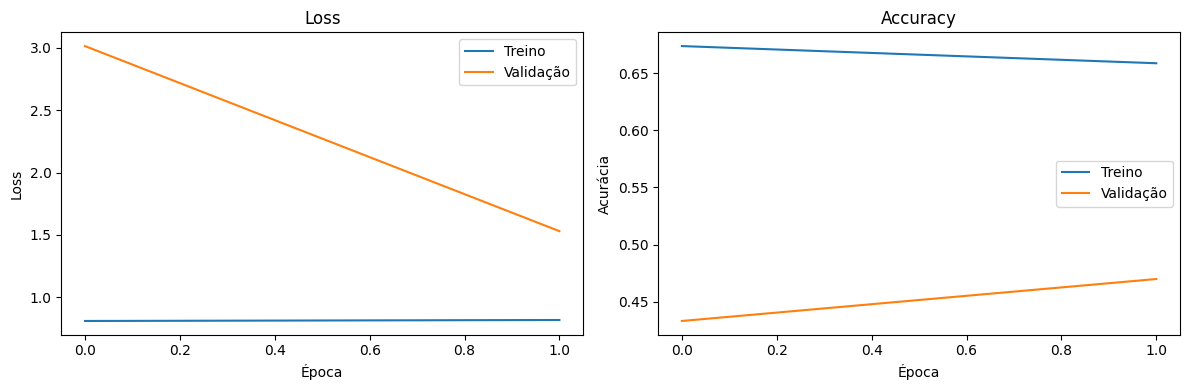

In [15]:

history_dict = history.history

# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treino')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Treino')
plt.plot(history_dict['val_accuracy'], label='Validação')
plt.title('Accuracy')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

        drum       0.78      0.18      0.30       137
      guitar       0.46      0.97      0.62       264
       piano       0.00      0.00      0.00       151
      violin       0.25      0.04      0.07        48

    accuracy                           0.47       600
   macro avg       0.37      0.30      0.25       600
weighted avg       0.40      0.47      0.35       600

confusion
[[ 25 110   0   2]
 [  5 255   0   4]
 [  2 149   0   0]
 [  0  46   0   2]]


/home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rcalabro/codebase/senac-ia/neural-networks/rn-musical-instruments/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

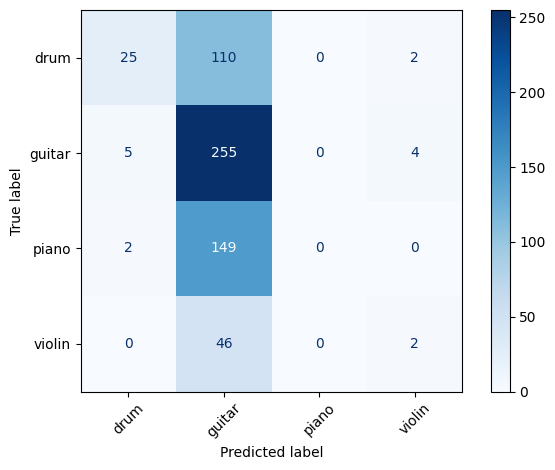

In [16]:
y_true = []
y_pred = []

for batch_x, batch_y in val_ds:
    preds = model.predict(batch_x, verbose=0)
    y_true.extend(batch_y.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Relatório de classificação
print(classification_report(y_true, y_pred, target_names=class_to_idx.keys()))


# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print('confusion')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_to_idx.keys()))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.tight_layout()
plt.show()